In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from PIL import Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.utils import plot_model




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
else :
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
all_images_path = []

images_train_path = "../input/butterfly-dataset/leedsbutterfly/images"

for path in os.listdir(images_train_path):
    if '.png' in path:
        all_images_path.append(os.path.join(images_train_path, path))
        
images_used = all_images_path[0:830]

print(images_used[2])

../input/butterfly-dataset/leedsbutterfly/images/0090201.png


In [4]:
training_data = [np.array(Image.open(path).resize((64,64))) for path in images_used]

#normalisation
for i in range(len(training_data)):
    training_data[i] = (training_data[i] - training_data[i].min()) / (255 - training_data[i].min())
    
training_data = np.array(training_data)

print(training_data.shape)

(830, 64, 64, 3)


<Figure size 1000x1000 with 0 Axes>

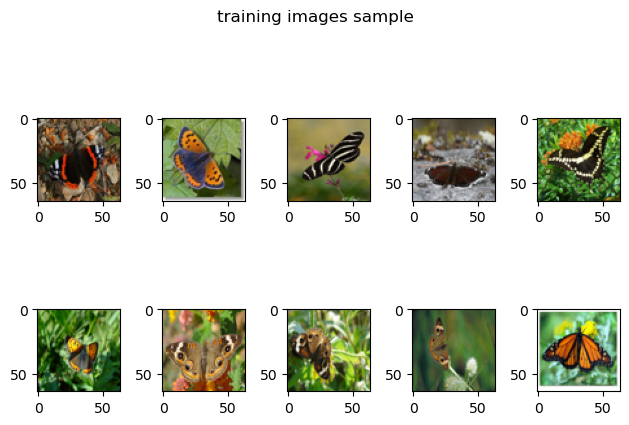

In [5]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("training images sample")
idx=8

for i in range(2):
    for j in range(5):
        ax[i,j].imshow(training_data[idx].reshape(64,64,3))
        idx+=10
        
plt.tight_layout()
plt.show()

In [6]:
noise_sh = 100

def Generator():
    generator = Sequential()
    
    generator.add(Dense(4*4*512, input_shape = [noise_sh]))
    generator.add(Reshape([4,4,512]))
    generator.add(Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = "same"))
                  
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))
    
    generator.add(Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = "same"))
    generator.add(LeakyReLU(alpha=0.2))
                  
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(64, kernel_size = 4, strides = 2, padding = "same"))
    generator.add(LeakyReLU(alpha=0.2))
    
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(3, kernel_size = 4, strides = 2, padding = "same", activation = "sigmoid"))
                  
    return generator
                  
                  
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        2097408   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      5

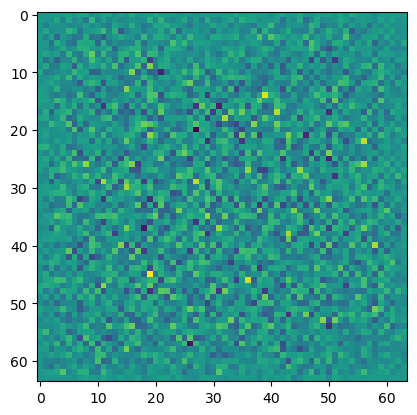

In [7]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0,:,:,0])

In [8]:
def Discriminator():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3,3), strides = (2,2), padding = "same", input_shape=[64,64,3]))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Conv2D(64, (3,3), strides = (2,2), padding = "same"))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Flatten())
    
    discriminator.add(Dense(1, activation = "sigmoid"))
                  
    return discriminator
                  
                  
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                      

In [9]:
GAN = Sequential([generator, discriminator])

discriminator.compile(optimizer='adam', loss = 'binary_crossentropy')

discriminator.trainable = False

GAN.compile(optimizer='adam', loss = 'binary_crossentropy')

GAN.layers

GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         3585219   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 55361     
                                                                 
Total params: 3,640,580
Trainable params: 3,584,323
Non-trainable params: 56,257
_________________________________________________________________


currently training on epoch 1
currently on batch 0 of 12


2023-07-13 08:55:52.451235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-13 08:55:55.880384: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/sequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 266ms/step


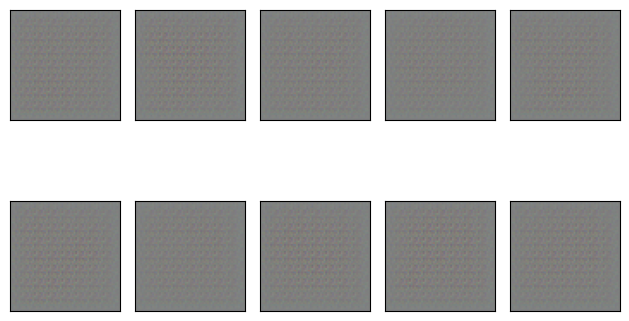

Epoch: 1, Loss: D_real = 0.836, D_fale = 0.206, G = 0.290
currently training on epoch 2
currently on batch 0 of 12
Epoch: 2, Loss: D_real = 0.044, D_fale = 0.073, G = 0.034
currently training on epoch 3
currently on batch 0 of 12
Epoch: 3, Loss: D_real = 0.002, D_fale = 0.002, G = 0.014
currently training on epoch 4
currently on batch 0 of 12
Epoch: 4, Loss: D_real = 0.000, D_fale = 0.000, G = 0.005
currently training on epoch 5
currently on batch 0 of 12
Epoch: 5, Loss: D_real = 0.000, D_fale = 0.000, G = 0.002
currently training on epoch 6
currently on batch 0 of 12
Epoch: 6, Loss: D_real = 0.000, D_fale = 0.000, G = 0.001
currently training on epoch 7
currently on batch 0 of 12
Epoch: 7, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 8
currently on batch 0 of 12
Epoch: 8, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 9
currently on batch 0 of 12
Epoch: 9, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on 

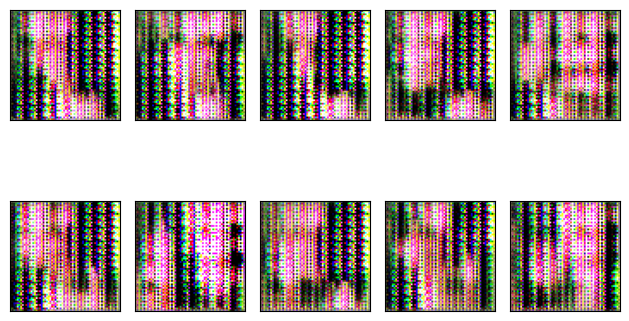

Epoch: 51, Loss: D_real = 0.000, D_fale = 0.090, G = 8.213
currently training on epoch 52
currently on batch 0 of 12
Epoch: 52, Loss: D_real = 0.063, D_fale = 0.034, G = 6.298
currently training on epoch 53
currently on batch 0 of 12
Epoch: 53, Loss: D_real = 0.010, D_fale = 0.086, G = 3.346
currently training on epoch 54
currently on batch 0 of 12
Epoch: 54, Loss: D_real = 0.002, D_fale = 0.023, G = 10.224
currently training on epoch 55
currently on batch 0 of 12
Epoch: 55, Loss: D_real = 0.007, D_fale = 0.057, G = 13.130
currently training on epoch 56
currently on batch 0 of 12
Epoch: 56, Loss: D_real = 0.013, D_fale = 0.046, G = 11.730
currently training on epoch 57
currently on batch 0 of 12
Epoch: 57, Loss: D_real = 0.031, D_fale = 0.005, G = 2.293
currently training on epoch 58
currently on batch 0 of 12
Epoch: 58, Loss: D_real = 0.002, D_fale = 0.000, G = 0.430
currently training on epoch 59
currently on batch 0 of 12
Epoch: 59, Loss: D_real = 0.000, D_fale = 0.001, G = 0.198
cu

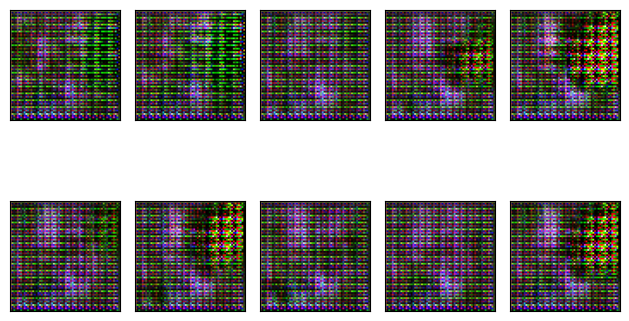

Epoch: 101, Loss: D_real = 0.000, D_fale = 0.000, G = 0.007
currently training on epoch 102
currently on batch 0 of 12
Epoch: 102, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 103
currently on batch 0 of 12
Epoch: 103, Loss: D_real = 0.000, D_fale = 0.000, G = 0.007
currently training on epoch 104
currently on batch 0 of 12
Epoch: 104, Loss: D_real = 0.000, D_fale = 0.000, G = 0.003
currently training on epoch 105
currently on batch 0 of 12
Epoch: 105, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 106
currently on batch 0 of 12
Epoch: 106, Loss: D_real = 0.000, D_fale = 0.000, G = 0.001
currently training on epoch 107
currently on batch 0 of 12
Epoch: 107, Loss: D_real = 0.000, D_fale = 0.000, G = 0.005
currently training on epoch 108
currently on batch 0 of 12
Epoch: 108, Loss: D_real = 0.000, D_fale = 0.000, G = 0.001
currently training on epoch 109
currently on batch 0 of 12
Epoch: 109, Loss: D_real = 0.000, D_fale = 0.000

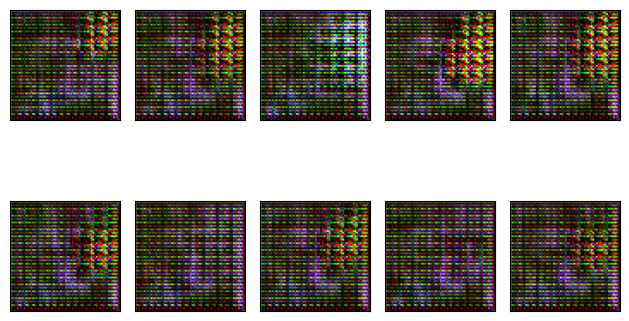

Epoch: 151, Loss: D_real = 0.000, D_fale = 0.000, G = 0.002
currently training on epoch 152
currently on batch 0 of 12
Epoch: 152, Loss: D_real = 0.000, D_fale = 0.000, G = 0.002
currently training on epoch 153
currently on batch 0 of 12
Epoch: 153, Loss: D_real = 0.000, D_fale = 0.000, G = 0.002
currently training on epoch 154
currently on batch 0 of 12
Epoch: 154, Loss: D_real = 0.000, D_fale = 0.000, G = 0.002
currently training on epoch 155
currently on batch 0 of 12
Epoch: 155, Loss: D_real = 0.000, D_fale = 0.000, G = 0.005
currently training on epoch 156
currently on batch 0 of 12
Epoch: 156, Loss: D_real = 0.000, D_fale = 0.000, G = 0.001
currently training on epoch 157
currently on batch 0 of 12
Epoch: 157, Loss: D_real = 0.000, D_fale = 0.000, G = 0.005
currently training on epoch 158
currently on batch 0 of 12
Epoch: 158, Loss: D_real = 0.002, D_fale = 0.000, G = 0.003
currently training on epoch 159
currently on batch 0 of 12
Epoch: 159, Loss: D_real = 0.000, D_fale = 0.000

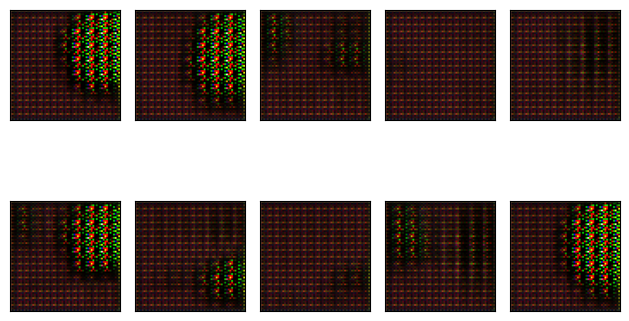

Epoch: 201, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 202
currently on batch 0 of 12
Epoch: 202, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 203
currently on batch 0 of 12
Epoch: 203, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 204
currently on batch 0 of 12
Epoch: 204, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 205
currently on batch 0 of 12
Epoch: 205, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 206
currently on batch 0 of 12
Epoch: 206, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 207
currently on batch 0 of 12
Epoch: 207, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 208
currently on batch 0 of 12
Epoch: 208, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 209
currently on batch 0 of 12
Epoch: 209, Loss: D_real = 0.000, D_fale = 0.000

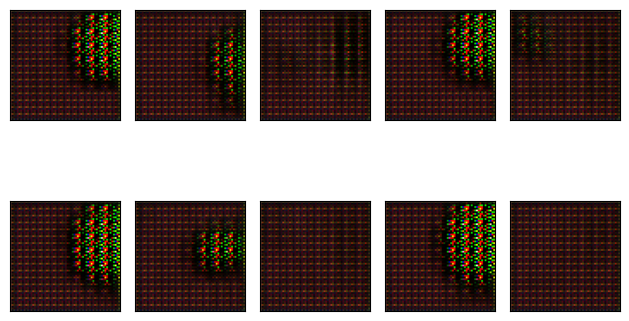

Epoch: 251, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 252
currently on batch 0 of 12
Epoch: 252, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 253
currently on batch 0 of 12
Epoch: 253, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 254
currently on batch 0 of 12
Epoch: 254, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 255
currently on batch 0 of 12
Epoch: 255, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 256
currently on batch 0 of 12
Epoch: 256, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 257
currently on batch 0 of 12
Epoch: 257, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 258
currently on batch 0 of 12
Epoch: 258, Loss: D_real = 0.000, D_fale = 0.000, G = 0.000
currently training on epoch 259
currently on batch 0 of 12
Epoch: 259, Loss: D_real = 0.000, D_fale = 0.000

In [10]:
epochs = 300
batch_size = 64

loss_disc = []
loss_gen = []

with tf.device("/gpu:0"):
    for epoch in range(epochs):
        print(f"currently training on epoch {epoch+1}")
        
        for i in range(training_data.shape[0] // batch_size):
            
            if(i)%100 == 0:
                print(f"currently on batch {i} of {len(training_data)//batch_size}")
             
            noise = np.random.uniform(-1, 1, size = [batch_size, noise_sh])
            gen_img = generator.predict_on_batch(noise)
            
            training_dataset = training_data[i * batch_size : (i+1) * batch_size]
            
            train_labels_real = np.ones(shape=(batch_size, 1))
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(training_dataset, train_labels_real)
            
            train_labels_fake = np.zeros(shape=(batch_size, 1))
            
            d_loss_fake = discriminator.train_on_batch(gen_img, train_labels_fake)
            
            noise = np.random.uniform(-1, 1, size=[batch_size, noise_sh])
            
            train_label_fake_for_gen_training = np.ones(shape=(batch_size, 1))
            
            discriminator.trainable = False
            
            g_loss = GAN.train_on_batch(noise, train_label_fake_for_gen_training)
            
            loss_disc.append(d_loss_real + d_loss_fake)
            
            loss_gen.append(g_loss)
            
        if epoch % 50 == 0:
            samples = 10
            x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))
            
            for k in range(samples):
                plt.subplot(2,5, k+1)
                plt.imshow(x_fake[k].reshape(64,64,3))
                plt.xticks([])
                plt.yticks([])
                
            plt.tight_layout()
            plt.show()
            
        print("Epoch: %d, Loss: D_real = %.3f, D_fale = %.3f, G = %.3f"
                 %(epoch+1, d_loss_real, d_loss_fake, g_loss))
            
    print("Trainig complete")
            
            
            